## RecipeToVec
Word to vec using gensim: https://radimrehurek.com/gensim/models/word2vec.html
Here we are creating the word vectors from the recipes.
Each document is one recipe's list of clean ingredients + verbs. 
We use the Gensim model to create the similarity matrix(cosine similarity).

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
#from gensim.models.word2vec import Word2Vec
from gensim import corpora, models, utils
import pickle
import os
import logging
import operator

Using TensorFlow backend.


In [2]:
# Enable logging (for gensim)
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pd.set_option('display.max_rows', 50)

cleanerIngredientsDict=pd.read_pickle('cleanerIngredients.pkl')  
verbsDict=pd.read_pickle('verbs.pkl') 

In [3]:
print len(cleanerIngredientsDict)
print len(verbsDict)
print verbsDict['http://allrecipes.com/recipe/33385/best-spanish-rice/']

48417
48417
[u'heat', u'stir', u'cook', u'mix', u'stir', u'begin', u'reduce', u'cover', u'simmer', u'absorb']


In [4]:
allRecipes=pd.read_pickle('CleanedIngredients.pkl')
allRecipes.drop_duplicates(subset='url', keep='first', inplace=True)
indexedRecipes=allRecipes.set_index("url")

In [86]:
recipes=[]
names=[]
categories=[]
for idx, row in allRecipes.iterrows():
    name = [word for word in row["name"].lower().split()]
    url = row["url"]
    verbs = verbsDict[url]
    if type(verbs) != list:
        print url
        print '%s is not a list' % verbs
        verbs=[]
    ingredients = list(cleanerIngredientsDict[url])
    cat=row["categories"]
    # Concatenate phrases into single tokens
    # ingredients=[i.replace(' ','_') for i in ingredients]
    recipes.append(name + cat + ingredients + verbs)
    names.append(row["name"])
    categories.append(row["categories"])

In [6]:
allRecipes.sample(1)

,categories,cookingTime,description,ingredients,instructionSteps,name,rating,ratingCount,url,cookingTimeMinutes,cleanedIngredients
2121,"[Hunt's, Trusted Brands, Shrimp Salad, Seafood...",PT10M,NaN,"[1 (15 ounce) can black beans, rinsed and drai...","[Combine black beans, corn, green chilies, tom...","Black Bean, Corn, Tomato, and Shrimp Salad",4.25,3,http://allrecipes.com/recipe/256312/black-bean...,10.0,"[black beans, corn, green chilies, tomatoes, g..."


In [7]:
print 'Total recipes loaded: %s ' % len(recipes)
print recipes[0]

Total recipes loaded: 48417 
[u'fresco', u'salsa', u'Tomato Salsa', u'Salsa', u'Dips and Spreads', u'Appetizers and Snacks', u'Mexican Recipes', u'Everyday Cooking', u'Recipes', u'Summer Appetizers', u'Mexican Appetizers', u'Cilantro', u'tomato', u'lime juice', u'cilantro', u'red bell pepper', u'onion', u'yellow bell pepper', u'salt', u'mix', u'lime', u'cover', u'refrigerate', u'serve']


In [8]:
# Create a dictionary and save it
dictionary = corpora.Dictionary(recipes)
dictionary.save('recipe2vec.dict')
print(dictionary)
print "The token ID of milk is: %s " % dictionary.token2id["milk"] 

Dictionary(27482 unique tokens: [u'', u'butter flavoring', u'hiyayakko', u'gai', u'blast-off']...)
The token ID of milk is: 63 


In [ ]:
# Create a corpus and save it
corpus = [dictionary.doc2bow(recipe) for recipe in recipes]
corpora.MmCorpus.serialize('recipe2vec.mm', corpus)

## Now let's build a model

if (os.path.exists("recipe2vec.dict")):
    dictionary = corpora.Dictionary.load('recipe2vec.dict')
    corpus = corpora.MmCorpus('recipe2vec.mm')
    print("Loaded dictionary and corpus from disk")
else:
    print("Error: Could find dictionary \"recipe2vec.dict\"")

tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100) # initialize an LSI transformation
corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->lsi

In [9]:
print len(recipes)

48417


In [10]:
taggedRecipes=[models.doc2vec.TaggedDocument(recipes[i], [i]) for i in range(len(recipes))]
print taggedRecipes[0]

TaggedDocument([u'fresco', u'salsa', u'Tomato Salsa', u'Salsa', u'Dips and Spreads', u'Appetizers and Snacks', u'Mexican Recipes', u'Everyday Cooking', u'Recipes', u'Summer Appetizers', u'Mexican Appetizers', u'Cilantro', u'tomato', u'lime juice', u'cilantro', u'red bell pepper', u'onion', u'yellow bell pepper', u'salt', u'mix', u'lime', u'cover', u'refrigerate', u'serve'], [0])


## Train a Doc2Vec model

In [11]:
print('Training a Doc2vec model...')
w2v_model = models.doc2vec.Doc2Vec(taggedRecipes, size=100, min_count=30, workers=4, iter=30, dm=0)

Training a Doc2vec model...


In [12]:
print('Let us see what this looks like...')
print taggedRecipes[0]
print  w2v_model.infer_vector(taggedRecipes[0].words)[:10]

Let us see what this looks like...
TaggedDocument([u'fresco', u'salsa', u'Tomato Salsa', u'Salsa', u'Dips and Spreads', u'Appetizers and Snacks', u'Mexican Recipes', u'Everyday Cooking', u'Recipes', u'Summer Appetizers', u'Mexican Appetizers', u'Cilantro', u'tomato', u'lime juice', u'cilantro', u'red bell pepper', u'onion', u'yellow bell pepper', u'salt', u'mix', u'lime', u'cover', u'refrigerate', u'serve'], [0])
[ 0.67699277 -0.12435573 -0.21078078 -0.04042995 -0.54262221  0.23174517
  0.26607651 -0.02978159 -0.01067518  0.19200471]


In [13]:
print "We can turn anything into a vector now"
print  w2v_model.infer_vector([u'chicken',u'masala'])[:10]

print "This is what the documents look like:"
for doc_id in range(50,55):
    print('Document ({}): «{}»\n'.format(doc_id, ' '.join(taggedRecipes[doc_id].words)))

We can turn anything into a vector now
[ 0.32363179 -0.14556076 -0.28759897 -0.01887761 -0.13736582  0.10399946
  0.01374498  0.02835013  0.2408634   0.1672677 ]
This is what the documents look like:
Document (50): «the best lemon bars Lemon Desserts Fruit Desserts Lemon Bars Bar Cookies Cookies Desserts Everyday Cooking Recipes Bake Sale Lemon Recipes butter flour lemon juice egg sugar preheat blend soften press bake whisk remain whisk pour bake firm cool use add give cool cut arrange»

Document (51): «crustless spinach quiche Breakfast Quiche Vegetarian Quiche Spinach Quiche Crustless Quiche Quiche Everyday Cooking Main Dishes Recipes Low-Carb Vegetarian Main Dishes Spinach Recipes cheese pepper oil onion spinach egg salt preheat grease heat add cook stir stir continue cook evaporate combine add blend scoop bake set let serve»

Document (52): «lime chicken soft tacos Mexican Recipes Skillet Chicken Breasts Mexican-Style Chicken Breasts Chicken Breasts Everyday Cooking Main Dishes Rec

In [14]:
print "And find recipes similar to other recipes"
w2v_model.docvecs.most_similar([w2v_model.infer_vector(taggedRecipes[0].words)], topn=5)

And find recipes similar to other recipes


[(0, 0.8306626677513123),
 (27379, 0.7990536689758301),
 (44757, 0.7934030890464783),
 (762, 0.7588169574737549),
 (27039, 0.7402241230010986)]

## How well of a representation is it? Are documents the most similar to themselves?  
Let see how many documents the model thinks are the most similar to themselves 

In [ ]:
from tqdm import tqdm as ProgressBar

ranks = []
second_ranks = []
top_ranks = []
diffs = []
for doc_id in ProgressBar(range(len(taggedRecipes)), desc="Processing recipes"):
    inferred_vector = w2v_model.infer_vector(taggedRecipes[doc_id].words)
    sims = w2v_model.docvecs.most_similar([inferred_vector], topn=len(w2v_model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    top_ranks.append(sims[0][1])
    second_ranks.append(sims[1])
    diffs.append(sims[0][1]-sims[1][1])
    #if doc_id==10:
    #    break

In [ ]:
import collections
c= collections.Counter(ranks)
print "{}% of the recipes were the model's top match. For another {}% they were #2.".format(c[0]/20000.0*100, c[1]/20000.0*100)
#print "The average similarity coefficient of the second best match is {}".format(top_ranks-diffs)
#print "The average diffecrence from the best match is {}".format(diffs)

## Save the results:
0: 83.85%, 1:4.53%  size=100, window=7, min_count=2, workers=4, iter=50  
0: 68.84%  1:5.31%  size=100, window=7, min_count=5, workers=4, iter=30  
0: 87.74%  1:4.04%  size=100, window=4, min_count=5, workers=4, iter=30  
0: 81.82%  1:4.74%  size=100, min_count=30, workers=4, iter=30
0: 58.59%  1:7.63%  size=50, min_count=20, workers=4, iter=30
0: 8.365%  1:3.32%  size=300, min_count=50, workers=4, iter=10, dm=0 (DBOW)  
0:                  size=100, min_count=30, workers=4, iter=30, dm=0) (DBOW)

## Search by URL (find recipes like this one)  
Here we look for for the parsed recipe in our data frame. In a more realistic (and useful) implementation, the recipe will be read and parsed and a BOW (ingredients, actions, name) will be used to look for similarities.

In [15]:
doc_id=indexedRecipes.index.get_loc('http://allrecipes.com/recipe/166638/baked-buffalo-wings/')
bag_of_words=taggedRecipes[doc_id].words
inferred_vector = w2v_model.infer_vector(bag_of_words)
sims=w2v_model.docvecs.most_similar([inferred_vector], topn=len(w2v_model.docvecs))
print 'Search URL: '
print allRecipes.iloc[doc_id]["name"]
print allRecipes.iloc[doc_id]["url"]
print 'Best match: (%s match)' % (100*sims[0][1])
print allRecipes.iloc[sims[0][0]]["name"]
print allRecipes.iloc[sims[0][0]]["url"]
for i in range(5):
    print 'Match #%s: (%s match)' % (i+1, 100*sims[i+1][1])
    print allRecipes.iloc[sims[i+1][0]]["name"]
    print allRecipes.iloc[sims[i+1][0]]["url"]


Search URL: 
Baked Buffalo Wings
http://allrecipes.com/recipe/166638/baked-buffalo-wings/
Best match: (69.2423582077 match)
Baked Buffalo Wings
http://allrecipes.com/recipe/166638/baked-buffalo-wings/
Match #1: (61.7095470428 match)
Praline Chicken
http://allrecipes.com/recipe/220112/praline-chicken/
Match #2: (54.9649238586 match)
Zach's Buffalo Wing Goodness
http://allrecipes.com/recipe/257352/zachs-buffalo-wing-goodness/
Match #3: (54.1871190071 match)
Lubed-Up Hot Wings
http://allrecipes.com/recipe/216687/lubed-up-hot-wings/
Match #4: (52.9257416725 match)
Jerry's Wings
http://allrecipes.com/recipe/14915/jerrys-wings/
Match #5: (52.9035568237 match)
Hot Wings
http://allrecipes.com/recipe/16802/hot-wings/


## Keywords Search

In [17]:
wordsVec=utils.simple_preprocess(u'flour butter water yeast mix dough bake beef')
inferred_vector = w2v_model.infer_vector(wordsVec)
sims=w2v_model.docvecs.most_similar([inferred_vector], topn=len(w2v_model.docvecs))
for i in range(5):
    print 'Match #%s: ' % (i)
    print allRecipes.iloc[sims[i][0]]["name"], sims[i][1]
    print allRecipes.iloc[sims[i][0]]["url"]

Match #0: 
Romanian Grilled Minced Meat Rolls 0.589578926563
http://allrecipes.com/recipe/92382/romanian-grilled-minced-meat-rolls/
Match #1: 
Pepperoni Burgers 0.566621959209
http://allrecipes.com/recipe/81135/pepperoni-burgers/
Match #2: 
Irish Brown Soda Bread 0.560040712357
http://allrecipes.com/recipe/17873/irish-brown-soda-bread/
Match #3: 
Mozzarella Meat Whirl 0.559168457985
http://allrecipes.com/recipe/30989/mozzarella-meat-whirl/
Match #4: 
Busy Mom's Spaghetti Bolognese 0.557772636414
http://allrecipes.com/recipe/217380/busy-moms-spaghetti-bolognese/


## Results


In [18]:
# Prebare all embeddings
v=[w2v_model.infer_vector(taggedRecipes[doc_id].words) for doc_id in range(len(taggedRecipes))]

In [22]:
uniqueCategories=set([category for categoryList in categories for category in categoryList ])
uniqueCategories.remove('Recipes') # remove junk categories
uniqueCategories.remove('Everyday Cooking')
print len(uniqueCategories)

2741


In [23]:
# compute model's accuracy using euclidean RSS from centroid of caetgories 
import math
from tqdm import tqdm as ProgressBar
numCat=len(categories)
print numCat
print len(v)
totalRSS=0
minRecipesPerCategory=100
results=defaultdict(int)
bag_of_words=taggedRecipes[doc_id].words
inferred_vector = w2v_model.infer_vector(bag_of_words)

for category in ProgressBar(list(uniqueCategories), desc="Processing categories"):
#for category in list(uniqueCategories):
    categoryEmbeddings = [v[idx] for idx in range(numCat) if category in categories[idx]]
    numRecipes = len(categoryEmbeddings)
    categoryCetroid = sum(categoryEmbeddings)/numRecipes
    RSS=math.sqrt(sum(sum([(v[idx]-categoryCetroid)**2 for idx in range(numCat) if category in categories[idx]])))
    totalRSS += RSS
    if numRecipes>=minRecipesPerCategory:
        results[category]=RSS/numRecipes
#    print 'found %s recipes in category %s. RootSumSq=%s' % (len(categoryEmbeddings), category, ss)
print len(categoryCetroid)
print totalRSS
for item in sorted(results.items(), reverse=False, key=operator.itemgetter(1))[:30]:
    print item

Processing categories:   0%|          | 1/2741 [00:00<06:47,  6.73it/s]

48417
48417


Processing categories: 100%|██████████| 2741/2741 [07:46<00:00,  6.01it/s]

100
80471.4116961
(u'Main Dishes', 0.028303467235634115)
(u'Desserts', 0.034975789304211746)
(u'Side Dishes', 0.048274730201244)
(u'Appetizers and Snacks', 0.04840585601186162)
(u'Drinks', 0.0506563071876674)
(u'Soups, Stews and Chili', 0.052710174125559776)
(u'Salad Recipes', 0.055281906437509305)
(u'Pasta by Shape', 0.05992821931516563)
(u'Cookies', 0.0611382952362333)
(u'Chicken Breasts', 0.06275053454193827)
(u'Bread Recipes', 0.06382211470822874)
(u'Soup', 0.0640179430999271)
(u'Faceless Recipes', 0.06441133934762214)
(u'Asian Recipes', 0.06467675920709981)
(u'Fruit Desserts', 0.06480218402082107)
(u'Breakfast and Brunch', 0.06575059422926631)
(u'Cake Recipes', 0.06839467065341188)
(u'Vanilla Extract', 0.0700312812034093)
(u'Dips and Spreads', 0.07129600462940486)
(u'Vegetable Side Dishes', 0.07163264118619114)
(u'Italian Recipes', 0.07326559865050698)
(u'Pasta Main Dishes', 0.07422103966075533)
(u'Mexican Recipes', 0.07445137283543667)
(u'Fish Recipes', 0.07471351712200389)
(u'Tr

In [63]:
# compute model's accuracy using cosine distance from centroid of caetgories 
import numpy as np
from tqdm import tqdm as ProgressBar
from scipy.spatial import distance
numCat=len(categories)
results2=defaultdict(int)
minRecipesPerCategory=100
print numCat
print len(v)
totalCosineDist=0
for category in ProgressBar(list(uniqueCategories), desc="Processing categories"):
#for category in list(uniqueCategories):
    categoryEmbeddings = [v[idx] for idx in range(numCat) if category in categories[idx]]
    numRecipes = len(categoryEmbeddings)
    categoryCetroid = sum(categoryEmbeddings)/numRecipes
    CosineDist=sum([distance.cosine(v[idx],categoryCetroid)**2 for idx in range(numCat) if category in categories[idx]])
    totalCosineDist += CosineDist
    if numRecipes>=minRecipesPerCategory:
        results2[category]= CosineDist/numRecipes
#    print 'found %s recipes in category %s. RootSumSq=%s' % (len(categoryEmbeddings), category, ss)
print len(categoryCetroid)
print totalCosineDist
for item in sorted(results2.items(), reverse=True, key=operator.itemgetter(1))[:30]:
    print item

Processing categories:   0%|          | 1/2741 [00:00<06:47,  6.72it/s]

48417
48417


Processing categories:   4%|▎         | 102/2741 [00:15<06:03,  7.26it/s]

KeyboardInterrupt: 

In [64]:
import tsne
import numpy as Math
import pylab as Plot

In [68]:
print "Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset."
print "Running example on 2,500 MNIST digits..."

X=np.array(v[:1000])
# Pick the 10 post popular categoties
cats=[u'Main Dishes',u'Desserts',u'Side Dishes',u'Appetizers and Snacks',\
        u'Drinks',u'Soups, Stews and Chili',u'Salad Recipes',u'Pasta by Shape',u'Cookies',\
        u'Chicken Breasts',u'Bread Recipes',u'Soup',u'Other',u'Fruit Recipes']
labels=[]
for recipe in categories:
    found=None
    for cat in recipe:
        if cat in cats:
            found=cat
            continue
    if found is None:
        found=u'Other'
    labels.append(found)
labels=np.array(labels)
labels=labels[:1000]
l=[cats.index(l) for l in labels]

Y = tsne.tsne(X, 2, 50, 20.0);
Plot.scatter(Y[:,0], Y[:,1], 20, labels);
Plot.show();

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  1000 ...
Computing P-values for point  500  of  1000 ...
Mean value of sigma:  0.821804853835
Iteration  10 : error is  19.7364260696
Iteration  20 : error is  19.1807388145
Iteration  30 : error is  19.2160304158
Iteration  40 : error is  19.2203215941
Iteration  50 : error is  19.524630126
Iteration  60 : error is  19.3763828749
Iteration  70 : error is  19.5018921711
Iteration  80 : error is  19.5706935658
Iteration  90 : error is  19.4155000028
Iteration  100 : error is  19.2399503184
Iteration  110 : error is  2.86365586007
Iteration  120 : error is  2.45319683802
Iteration  130 : error is  2.29914353636
Iteration  140 : error is  2.21485393954
Iteration  150 : error is  2.15401950248
Iteration  160 : error is  2.09889290488
Iteration  170 : error is  2.038390446

ValueError: Invalid RGBA argument: u'Appetizers and Snacks'

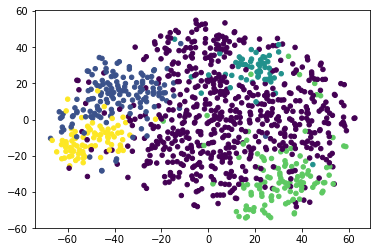

In [125]:
cats=[u'Other', u'Desserts',u'Salad Recipes', u'Soups, Stews and Chili',u'Bread Recipes']#,,u'Appetizers and Snacks',]
labels=[]
for recipe in categories:
    found=None
    for cat in recipe:
        if cat in cats:
            found=cat
            continue
    if found is None:
        found=u'Other'
    labels.append(found)
labels=np.array(labels)
labels=labels[:1000]
#print labels[:5]
#print cats.index(u'Desserts')
l=[cats.index(l) for l in labels]
Plot.scatter(Y[:,0], Y[:,1], 20, l);
Plot.show();

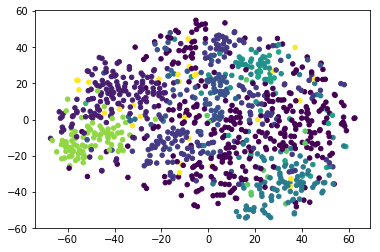

In [94]:
Plot.scatter(Y[:,0], Y[:,1], 20, l);
Plot.show();

In [85]:
print len(categories)

13
